In [23]:
import pandas as pd 
import numpy as np 
import datetime as dt 

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yfin
from pandas_datareader import  data as pdr 


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
import matplotlib as mpl
mpl.rcParams.update({'text.color' : 'black',
            'axes.labelcolor' : 'black','xtick.color': 'black','ytick.color': 'black'})

In [144]:
df = pd.read_csv('data/Bitcoin_data.csv')
df.head()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,1676939580000,2023-02-21 00:33:00,BTC/USD,24859.34,24859.34,24859.34,24859.34,0.000000,0.000000
1,1676939520000,2023-02-21 00:32:00,BTC/USD,24821.96,24859.34,24821.96,24859.34,0.103099,2562.977818
2,1676939460000,2023-02-21 00:31:00,BTC/USD,24818.09,24821.96,24815.47,24821.96,0.090640,2249.866178
3,1676939400000,2023-02-21 00:30:00,BTC/USD,24812.25,24818.09,24812.25,24818.09,0.002203,54.681450
4,1676939340000,2023-02-21 00:29:00,BTC/USD,24809.27,24812.25,24809.27,24812.25,0.090675,2249.862431


In [145]:
df = df.sort_values(by='Timestamp')
df['Date'] = pd.to_datetime(df['Date'],format= '%Y-%m-%d %H:%M:%S')

df.columns

Index(['Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume BTC', 'Volume USD'],
      dtype='object')

## We will focus on Bitcoin Closing Price Prediction
The 'Close' column represents the final price in the crypto-market

In [153]:
price_df = pd.DataFrame(df[['Date','Close']])
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3766763 entries, 3766762 to 0
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Close   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 86.2 MB


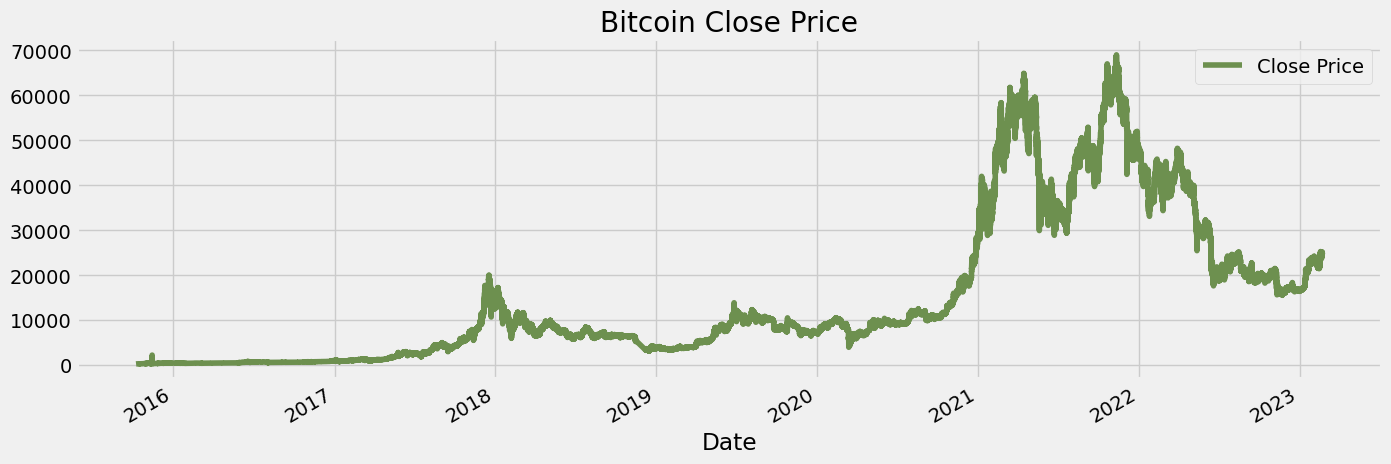

In [38]:
price_df.plot(style='-',figsize=(15,5),color=color_pal[3],title='Bitcoin Close Price')
plt.legend(['Close Price'])
plt.show()

In [154]:
price_df = price_df.groupby('Date')
price_df = pd.DataFrame(price_df['Close'].mean())

In [204]:
# Since my raw data is for every minute, I can probably predict for every hour
# So I will set the prediction_interval as 60 which is 60 min = 1 hr
prediction_interval = 60

train_raw = price_df[:len(price_df)-prediction_interval]
test_raw = price_df[len(price_df)-prediction_interval:]

In [205]:
from sklearn.preprocessing import MinMaxScaler

### Data Pre-processing ###

# Extraction and Reshaping to numpy array
train = train_raw.values
test = test_raw.values 

train = np.reshape(train, (len(train), 1))
test = np.reshape(test, (len(test), 1))

# Scaling the train and test datasets separately
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

sc_x_train = scaler_train.fit_transform(train)
sc_x_test = scaler_test.fit_transform(test)

# Creating Input Features and Target suitable for RNN
X_train = sc_x_train[0:len(sc_x_train)-1]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

y_train = sc_x_train[0:len(sc_x_train)]

# Reshape y_test for consistency with X_train
X_test = np.reshape(sc_x_test, (len(sc_x_test), 1, 1))


### Using Long Term Short Term Memory Recurrent Neural Network Model

In [206]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [207]:
# Create a Neural Network
model = Sequential()

# Adding the Input and Output layer
model.add(LSTM(units=4, activation='sigmoid', input_shape=(None, 1)))
model.add(Dense(units=1))
model.add(Dropout(0.2))
model.add(Dense(units=1))


# Compiling the RNN
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=1000, epochs=3)

Epoch 1/3
3767/3767 [==============================] - 9s 2ms/step - loss: 0.0086
Epoch 2/3
3767/3767 [==============================] - 7s 2ms/step - loss: 4.1068e-06
Epoch 3/3
3767/3767 [==============================] - 7s 2ms/step - loss: 3.6719e-06


In [208]:
# Making the Predictions
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

2/2 [==============================] - 0s 4ms/step


In [209]:
# Compiling the final result by creating a dictionary wherein keys are columns while values are the numpy array
compile_report = {'Original':test.flatten(),'Predicted Price':predicted_price.flatten()}
results = pd.DataFrame(compile_report)

# Copying the index from test_raw dataframe
results.index = test_raw.index
results.head()

,Original,Predicted Price
Date,,
2023-02-20 23:34:00,24761.49,24795.716797
2023-02-20 23:35:00,24776.29,24805.126953
2023-02-20 23:36:00,24776.29,24805.126953
2023-02-20 23:37:00,24776.29,24805.126953
2023-02-20 23:38:00,24769.97,24801.066406


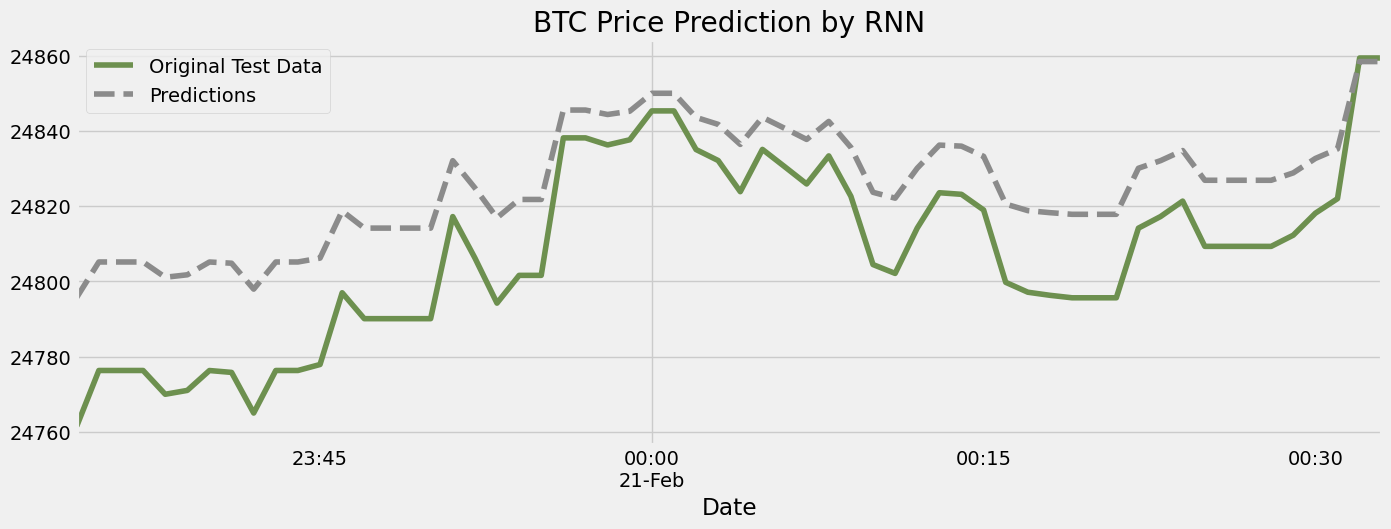

In [210]:
# Prediction Visualization
ax = results['Original'].plot(figsize=(15,5),color=color_pal[3])
results['Predicted Price'].plot(ax=ax, style='--',color=color_pal[4])
plt.legend(['Original Test Data','Predictions'])
plt.title('BTC Price Prediction by RNN')
plt.show()

In [185]:
price_df.head()

,Close
Date,
2015-10-08 13:40:00,242.50
2015-10-08 13:41:00,242.95
2015-10-08 13:42:00,242.95
2015-10-08 13:43:00,242.96
2015-10-08 13:44:00,242.96
